<a href="https://colab.research.google.com/github/alexis12895/TFG_practica/blob/main/Redes_neuronales/Prediccion_de_Acciones_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#SOLO SI QUIEREMOS importar ficheros desde GOOGLE COLAB de aqui, NO HACE FALTA EJECUTARLO
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#0. LIBRERIAS

#Usamos Numpy y ajustamos la semilla del generador aleatorio
import numpy as np
np.random.seed(4) #Nos permite replicar el entrenamiento en otro ordenador, garantiza que los parametros se inicializan de forma aleatoria pero con los mismos valores.
import matplotlib.pyplot as plt

#Leemos el set de datos csv
import pandas as pd

#para normalizar los valores(ponerlos entre 0 y 1)
from sklearn.preprocessing import MinMaxScaler

#Para implementar el modelo de red LSTM
from keras.models import Sequential #Para crear el contenedor al cual le añadiremos la red LSTM
from keras.layers import LSTM, Dense  #capa LSTM y capa de salida con Dense

In [ ]:
#1. SET DE DATOS

dataset = pd.read_csv('https://raw.githubusercontent.com/codificandobits/Prediccion_de_acciones_en_la_bolsa_con_redes_LSTM/master/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

#Usaremos el valor mas alto(High) para entrenar la red LSTM

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


              High
Date              
2006-01-03   10.68
2006-01-04   10.85
2006-01-05   10.70
2006-01-06   10.96
2006-01-09   11.03
...            ...
2016-12-23  116.52
2016-12-27  117.80
2016-12-28  118.02
2016-12-29  117.11
2016-12-30  117.20

[2768 rows x 1 columns]
              High
Date              
2017-01-03  116.33
2017-01-04  116.51
2017-01-05  116.86
2017-01-06  118.16
2017-01-09  119.43
...            ...
2017-12-22  175.42
2017-12-26  171.47
2017-12-27  170.78
2017-12-28  171.85
2017-12-29  170.59

[251 rows x 1 columns]


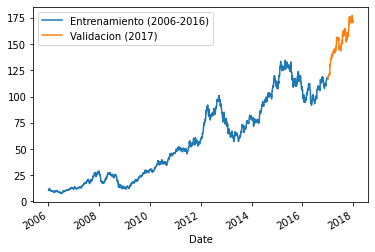

In [ ]:
#1. PRE-PROCESAMIENTO DE LOS DATOS

#1.1 Creacion de los sets de entrenamiento y validacion

#para el entrenamiento  usaremos datos de 2006 a 2016 y para prediccion y la validacion usaremos 2017
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]  #con iloc nos dice que cogera solo la columna 'High' Y 'Date', es decir, todos los elementos de las 2 primeras columnas, pero como tenemos [:,1], cogemos solo la primera columna y la columna 1(High), porque Date siempre saldra, ya que es su indice
set_validacion = dataset['2017':].iloc[:,1:2]
print(set_entrenamiento)
print(set_validacion)

#Grafico del entrenamiento
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validacion (2017)'])
plt.show()

#Para entrnar los valores normalizamos los valores entre 0 y 1
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
#print(set_entrenamiento_escalado)

In [ ]:
#1.2 Ajuste de los sets de entrenamiento y validacion

#tomaremos bloques de 60 datos almacenados en x y con estos predecir el sisguiente valor(61), almacenado en y
#la red LSTM tendra como entrada 'time_step' datos consecutivos y como salida 1 dato(la prediccion) a partir de esos 'time_step'
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):

  #X: bloques de 'times_step' datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
  X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

  #Y: el siguiente dato
  Y_train.append(set_entrenamiento_escalado[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

#antes de crear la red LSTM debemos reajustar los bloques obtenidos(X_train) para indicar que cada ejemplo de entrada(bloque) sera un vector de 60x1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#2. RED LSTM y ENTRENAMIENTO

#2.1 Implementacion del modelo de red LSTM

#definimos el tam de datos de entrada, dato de salida y num total de neuronas(50)
dim_entrada = (X_train.shape[1], 1)
dim_salida = 1
na = 50

#creamos el contenedor
modelo = Sequential()

#añadimos la red LSTM con add y le indicamos el num de neuronas(na), tam de cada de entrada(dim_entrada)
modelo.add(LSTM(units=na, input_shape=dim_entrada))

#añadimos la capa de salida con Dense y decimos el dato de salida(units = 1)
modelo.add(Dense(units=dim_salida))

#compilamos el modelo indicale la funcion de error(loss) y el metodo para minimizarla(optimizier = rmsprop)
modelo.compile(optimizer='rmsprop', loss='mse')  #rmsprop es similar a Gradiente Descendente y mse, es el error cuadratico medio(la diferencia de error entre el valor real y el predicho)

#2.2 Entrenamiento: iter = 20(epochs) y con 32 datos en cada iter
modelo.fit(X_train, Y_train, epochs=100, batch_size=32) #si en epochs ponemos 20, saldra en el grafico una prediccion cortita, pero si ponemos 100 como ahora , nos indica una larga prediccion acorde a los datos de validacion



Epoch 1/100
85/85 [==============================] - 4s 28ms/step - loss: 0.0057
Epoch 2/100
85/85 [==============================] - 2s 27ms/step - loss: 0.0011
Epoch 3/100
85/85 [==============================] - 2s 26ms/step - loss: 7.1744e-04
Epoch 4/100
85/85 [==============================] - 2s 28ms/step - loss: 5.3544e-04
Epoch 5/100
85/85 [==============================] - 2s 27ms/step - loss: 4.9426e-04
Epoch 6/100
85/85 [==============================] - 2s 27ms/step - loss: 4.4123e-04
Epoch 7/100
85/85 [==============================] - 2s 27ms/step - loss: 3.6579e-04
Epoch 8/100
85/85 [==============================] - 2s 26ms/step - loss: 3.5198e-04
Epoch 9/100
85/85 [==============================] - 2s 27ms/step - loss: 3.2177e-04
Epoch 10/100
85/85 [==============================] - 2s 27ms/step - loss: 3.0323e-04
Epoch 11/100
85/85 [==============================] - 2s 28ms/step - loss: 2.9638e-04
Epoch 12/100
85/85 [==============================] - 2s 27ms/step - lo

In [ ]:
#Funcion auxiliar para ver la prediccion de los valores de Apple
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')  #La linea roja el numero de filas que tenga prediccion, y como  solo hay una columna(hihg) en el set, pues eso columna =0
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


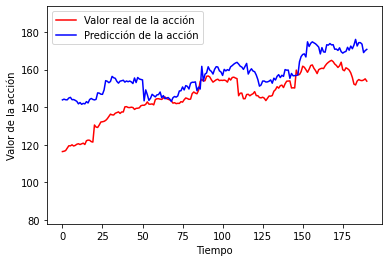

In [ ]:
#3. PREDICCION DEL VALOR DE LA ACCION

#normalizamos los datos(entre 0 y 1) que vamos a usar ahora para la validacion, recuerdo que son los de 2017
x_test = set_validacion.values
#print(x_test)
x_test = sc.transform(x_test)
#print(x_test)

#reorganizamos el set de validacion para que tenga bloques de 60 datos, por que el modelo fue entrenado para tomar bloques de 60 datos y generar un dato como prediccion
X_test = []
for i in range(time_step, len(x_test)):
  X_test.append(x_test[i-time_step:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1) )
#print(X_test)

#realizamos la prediccion y hacemos una normalizacion inversa(no 0 y 1) para que tenga una escala real
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

graficar_predicciones(set_validacion.values, prediccion)